In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

from skimage.transform import resize
from skimage.io import imread


from tqdm import tqdm
import pickle

# 병렬연산
from concurrent.futures import ThreadPoolExecutor

import os
import warnings
warnings.filterwarnings(action='ignore')

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

In [5]:
### 사용자 정의 함수
%cd /content/drive/MyDrive/project3

# Add the paths to the modules to the Python path
import sys
sys.path.append(os.path.abspath('./code/image_function'))

from image_load import resize_image, load_image, load_and_resize_images
from vram_reset import reset_vram

/content/drive/.shortcut-targets-by-id/1gdU-KuXDUU7v2o8X7TdV0JgGiz603mCc/project3


In [8]:
datadir = '/content/drive/MyDrive/project3/data/traindata/kfood/'

food_middle_list = sorted(os.listdir(datadir))
food_middle_list[:5]

['구이', '국', '기타', '김치', '나물']

In [9]:
food_list = [] # 음식이름
food_path_list = [] # 음식이름 경로

for food_middle in food_middle_list:
    middle_path = os.path.join(datadir,food_middle)
    food_name_list = os.listdir(middle_path)

    for food in food_name_list:
        path = os.path.join(middle_path,food)
        food_path_list.append(path)

        name = path.split('/')[-1]
        food_list.append(name)

print(len(food_list))
print(food_list)
print(food_path_list)

99
['갈비구이', '갈치구이', '고등어구이', '곱창구이', '닭갈비', '장어구이', '조개구이', '떡갈비', '불고기', '삼겹살', '더덕구이', '조기구이', '황태구이', '훈제오리', '콩나물국', '계란국', '떡국_만두국', '시래기국', '무국', '북엇국', '미역국', '육개장', '과메기', '편육', '콩자반', '양념치킨', '피자', '후라이드치킨', '젓갈', '갓김치', '깍두기', '나박김치', '무생채', '배추김치', '부추김치', '열무김치', '백김치', '총각김치', '오이소박이', '파김치', '가지볶음', '고사리나물', '미역줄기볶음', '숙주나물', '시금치나물', '애호박볶음', '송편', '꿀떡', '경단', '만두', '장', '적', '장아찌', '전', '전골', '조림', '라면', '쫄면', '짬뽕', '물냉면', '짜장면', '비빔냉면', '수제비', '막국수', '잔치국수', '열무국수', '칼국수', '콩국수', '도토리묵', '콩나물무침', '꽈리고추무침', '도라지무침', '잡채', '홍어무침', '회무침', '김밥', '김치볶음밥', '누룽지', '알밥', '비빔밥', '자

In [10]:
new_img_size = (224,224)
pic_count = 10
food_count = 15
food_path_list2 = food_path_list[:food_count]

image_list, target_list, except_list = load_and_resize_images(food_path_list2, food_list, img_size = new_img_size)

Processing images: 100%|██████████| 15/15 [01:53<00:00,  7.54s/it]


In [ ]:
food_list = [] # 음식이름
food_path_list = [] # 음식이름 경로

for food_middle in food_middle_list:
    middle_path = os.path.join(datadir,food_middle)
    food_name_list = os.listdir(middle_path)

    for food in food_name_list:
        path = os.path.join(middle_path,food)
        food_path_list.append(path)

        name = path.split('/')[-1]
        food_list.append(name)

print(len(food_list))
print(food_list)
print(food_path_list)

In [12]:
np.unique(target_list)

array(['갈비구이', '갈치구이', '고등어구이', '곱창구이', '닭갈비',
       '더덕구이', '떡갈비', '불고기', '삼겹살', '장어구이',
       '조개구이', '조기구이', '콩나물국', '황태구이', '훈제오리'],
      dtype='<U11')

In [17]:
categories_label = {category:i for i, category in enumerate(np.unique(target_list))} # 카테고리랑 숫자로 바꾼 값 dict형태로 만들기
target_num = np.array([categories_label[category] for category in target_list], dtype=np.int8)

In [18]:
categories_label

{'갈비구이': 0,
 '갈치구이': 1,
 '고등어구이': 2,
 '곱창구이': 3,
 '닭갈비': 4,
 '더덕구이': 5,
 '떡갈비': 6,
 '불고기': 7,
 '삼겹살': 8,
 '장어구이': 9,
 '조개구이': 10,
 '조기구이': 11,
 '콩나물국': 12,
 '황태구이': 13,
 '훈제오리': 14}

In [19]:
target_num

array([2, 2, 0, ..., 4, 9, 4], dtype=int8)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(image_list, target_num, test_size=0.2, random_state=42, )
X_train = X_train / 255.0
X_test = X_test / 255.0

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(X_train,y_train,epochs = 20,validation_split = 0.2)

Epoch 1/20
30/30 [==============================] - 8s 67ms/step - loss: 2.7257 - accuracy: 0.0764 - val_loss: 2.6742 - val_accuracy: 0.0667
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 2.6125 - accuracy: 0.1161 - val_loss: 2.6686 - val_accuracy: 0.1042
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 2.4857 - accuracy: 0.1611 - val_loss: 2.5542 - val_accuracy: 0.1292
Epoch 4/20
30/30 [==============================] - 1s 17ms/step - loss: 2.3959 - accuracy: 0.1841 - val_loss: 2.5429 - val_accuracy: 0.1167
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 2.3113 - accuracy: 0.2186 - val_loss: 2.5535 - val_accuracy: 0.1583
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 2.1340 - accuracy: 0.2856 - val_loss: 2.4779 - val_accuracy: 0.1833
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 1.8652 - accuracy: 0.3808 - val_loss: 2.6245 - val_accuracy: 0.1667
Epoch 8/20
30

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

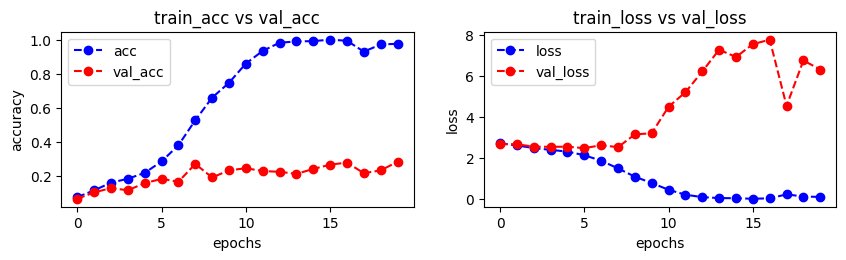

In [25]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

In [26]:
predictions = model.predict(X_test)

# Convert the logits to probabilities
probabilities = tf.nn.softmax(predictions)

# Get the class with the highest probability
predicted_classes = np.argmax(probabilities, axis=1)

# Compare the predicted classes with the actual classes
comparison = list(zip(predicted_classes, y_test))

# Display the first 10 predictions and actual values
for i in range(10):
    print(f'Predicted: {predicted_classes[i]}, Actual: {y_test[i]}')

10/10 [==============================] - 0s 28ms/step
Predicted: 1, Actual: 11
Predicted: 7, Actual: 9
Predicted: 5, Actual: 4
Predicted: 9, Actual: 3
Predicted: 6, Actual: 10
Predicted: 0, Actual: 0
Predicted: 3, Actual: 6
Predicted: 8, Actual: 10
Predicted: 1, Actual: 1
Predicted: 7, Actual: 6
